<a href="https://colab.research.google.com/github/mayur7garg/66DaysOfData/blob/main/Day%202/Probability_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probability Calibration

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

## Constants

In [2]:
RANDOM_STATE = 7
N_BINS = 10

## Dataset Creation

### Creating dummy data

In [3]:
X, y = make_classification(
    n_samples = 15000, 
    n_features = 50, 
    n_informative = 30, 
    n_redundant = 20,
    weights = [.75, .25],
    random_state = RANDOM_STATE
)

X.shape, y.shape

((15000, 50), (15000,))

In [4]:
np.bincount(y), np.unique(y)

(array([11206,  3794]), array([0, 1]))

### Splitting the data into equal sized train, valid and test datasets

In [5]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size = 10_000, random_state = RANDOM_STATE, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_, y_, test_size = 5_000, random_state = RANDOM_STATE, stratify = y_)
X_train.shape, y_train.shape, X_valid.shape, X_test.shape, y_valid.shape, y_test.shape

((5000, 50), (5000,), (5000, 50), (5000, 50), (5000,), (5000,))

## Calibration

### Expected Calibration Error

<img src="https://raw.githubusercontent.com/mayur7garg/66DaysOfData/main/Data/Images/Expected%20Calibration%20Error.png"/>

In [6]:
def expected_calibration_error(y, proba, bins = 'fd'): #'fd' -> Freedman–Diaconis rule for creating bins in histogram

  bin_count, bin_edges = np.histogram(proba, bins = bins)
  n_bins = len(bin_count)
  bin_edges[0] -= 1e-8 # because left edge is not included
  bin_id = np.digitize(proba, bin_edges, right = True) - 1
  bin_ysum = np.bincount(bin_id, weights = y, minlength = n_bins)
  bin_probasum = np.bincount(bin_id, weights = proba, minlength = n_bins)
  bin_ymean = np.divide(bin_ysum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
  bin_probamean = np.divide(bin_probasum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
  ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)
  return ece

### Random Forest

#### Model Training
Training the model on train data and predicting on validation and test data

In [7]:
forest = RandomForestClassifier().fit(X_train, y_train)
proba_valid = forest.predict_proba(X_valid)[:, 1]
proba_test = forest.predict_proba(X_test)[:, 1]

#### Model Calibration
Training the calibrator on predicted values of validation data and predicting on predicted values of test data

##### Isotonic Regression

In [8]:
iso_reg = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_valid, y_valid)
proba_test_isoreg = iso_reg.predict(proba_test)

##### Logistic Regression

In [9]:
log_reg = LogisticRegression().fit(proba_valid.reshape(-1, 1), y_valid)
proba_test_logreg = log_reg.predict_proba(proba_test.reshape(-1, 1))[:, 1]

#### Calibration Error on Test data

##### Random Forest model

In [10]:
expected_calibration_error(y_test, proba_test)

0.13561599999999996

##### Isotonic Regression

In [11]:
expected_calibration_error(y_test, proba_test_isoreg)

0.013466141864637456

##### Logistic Regression

In [12]:
expected_calibration_error(y_test, proba_test_logreg)

0.014612092958061117

#### Calibration Curves

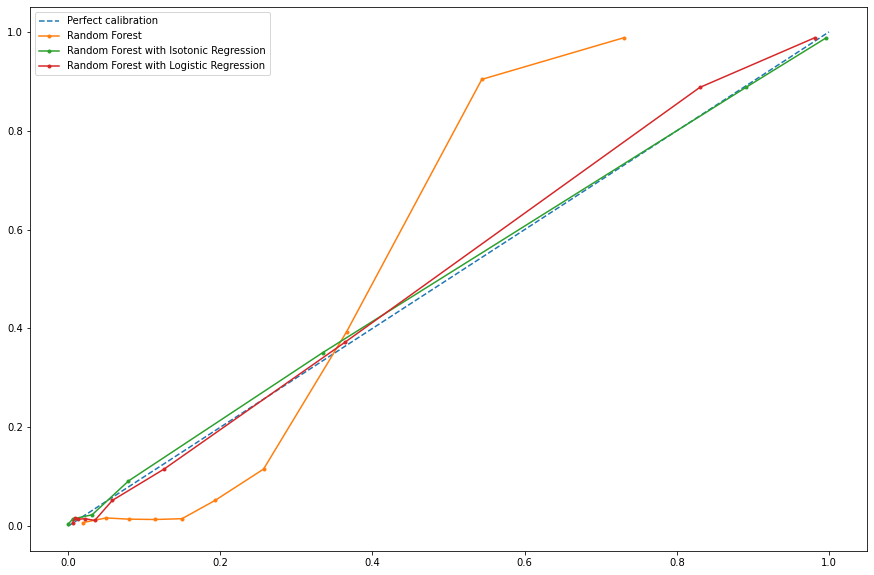

In [13]:
y_means, proba_means = calibration_curve(y_test, proba_test, n_bins = N_BINS, strategy = "quantile")
y_isoreg_means, proba_isoreg_means = calibration_curve(y_test, proba_test_isoreg, n_bins = N_BINS, strategy = "quantile")
y_logreg_means, proba_logreg_means = calibration_curve(y_test, proba_test_logreg, n_bins = N_BINS, strategy = "quantile")

plt.figure(figsize = (15, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means, y_means, label = 'Random Forest', marker = '.')
plt.plot(proba_isoreg_means, y_isoreg_means, label = 'Random Forest with Isotonic Regression', marker = '.')
plt.plot(proba_logreg_means, y_logreg_means, label = 'Random Forest with Logistic Regression', marker = '.')
plt.legend();

#### Probability Histogram

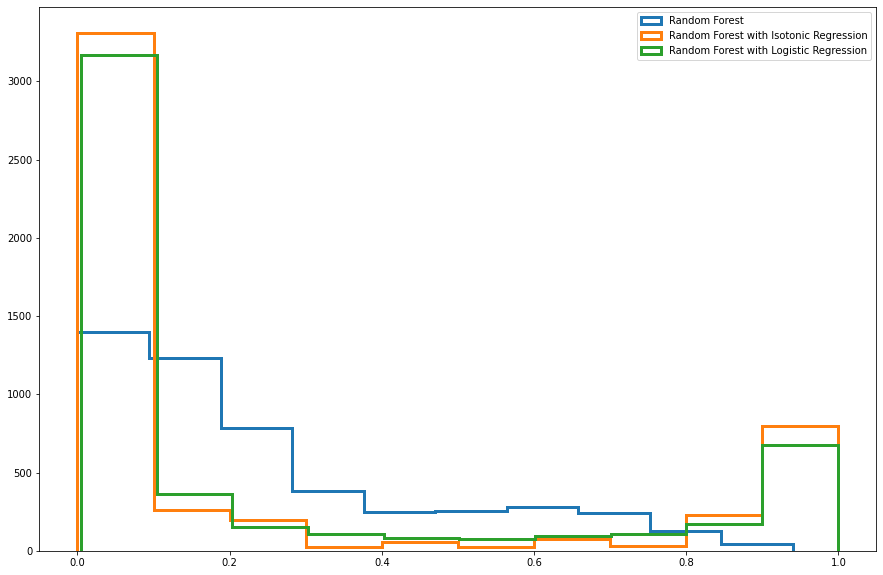

In [14]:
plt.figure(figsize = (15, 10))
plt.hist(proba_test, bins = N_BINS, histtype='step', linewidth = 3, label = 'Random Forest')
plt.hist(proba_test_isoreg, bins = N_BINS, histtype='step', linewidth = 3, label = 'Random Forest with Isotonic Regression')
plt.hist(proba_test_logreg, bins = N_BINS, histtype='step', linewidth = 3, label = 'Random Forest with Logistic Regression')
plt.legend();

### Gaussian Naive Bayes

#### Model Training
Training the model on train data and predicting on validation and test data

In [15]:
gnb = GaussianNB().fit(X_train, y_train)
proba_valid = gnb.predict_proba(X_valid)[:, 1]
proba_test = gnb.predict_proba(X_test)[:, 1]

#### Model Calibration
Training the calibrator on predicted values of validation data and predicting on predicted values of test data

##### Isotonic Regression

In [16]:
iso_reg = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba_valid, y_valid)
proba_test_isoreg = iso_reg.predict(proba_test)

##### Logistic Regression

In [17]:
log_reg = LogisticRegression().fit(proba_valid.reshape(-1, 1), y_valid)
proba_test_logreg = log_reg.predict_proba(proba_test.reshape(-1, 1))[:, 1]

#### Calibration Error on Test data

##### Gaussian NB Model

In [18]:
expected_calibration_error(y_test, proba_test)

0.07258030260298103

##### Isotonic Regression

In [19]:
expected_calibration_error(y_test, proba_test_isoreg)

0.015471785886628947

##### Logistic Regression

In [20]:
expected_calibration_error(y_test, proba_test_logreg)

0.03355668173937222

#### Calibration Curves

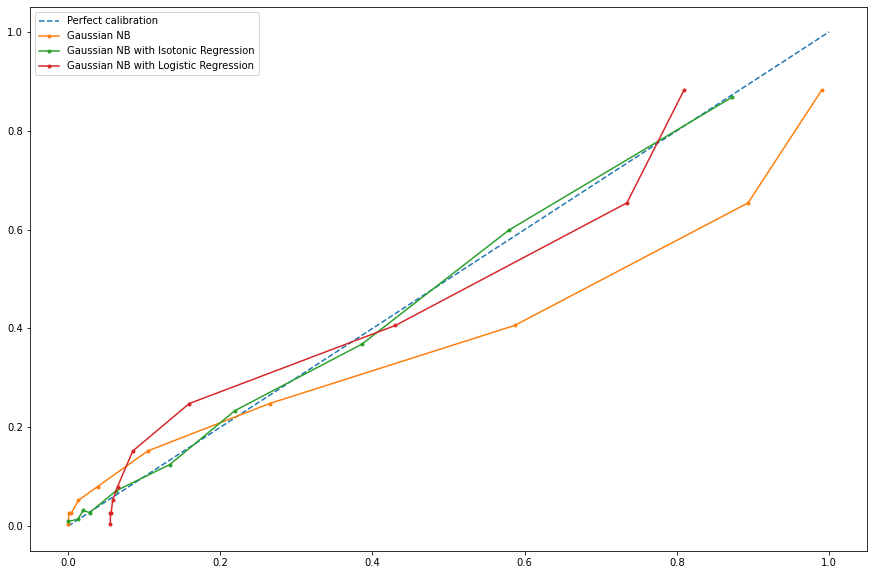

In [21]:
y_means, proba_means = calibration_curve(y_test, proba_test, n_bins = N_BINS, strategy = "quantile")
y_isoreg_means, proba_isoreg_means = calibration_curve(y_test, proba_test_isoreg, n_bins = N_BINS, strategy = "quantile")
y_logreg_means, proba_logreg_means = calibration_curve(y_test, proba_test_logreg, n_bins = N_BINS, strategy = "quantile")

plt.figure(figsize = (15, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means, y_means, label = 'Gaussian NB', marker = '.')
plt.plot(proba_isoreg_means, y_isoreg_means, label = 'Gaussian NB with Isotonic Regression', marker = '.')
plt.plot(proba_logreg_means, y_logreg_means, label = 'Gaussian NB with Logistic Regression', marker = '.')
plt.legend();

#### Probability Histogram

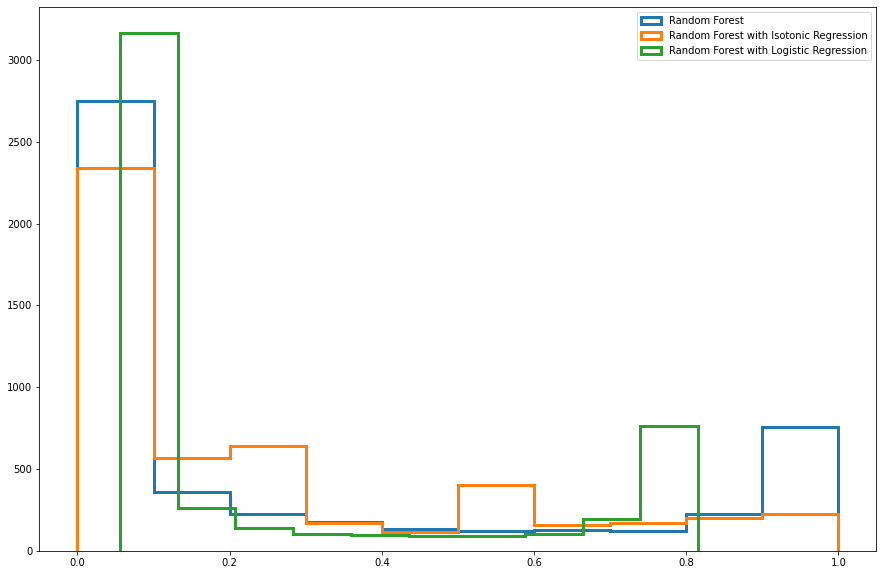

In [22]:
plt.figure(figsize = (15, 10))
plt.hist(proba_test, bins = N_BINS, histtype='step', linewidth = 3, label = 'Random Forest')
plt.hist(proba_test_isoreg, bins = N_BINS, histtype='step', linewidth = 3, label = 'Random Forest with Isotonic Regression')
plt.hist(proba_test_logreg, bins = N_BINS, histtype='step', linewidth = 3, label = 'Random Forest with Logistic Regression')
plt.legend();